In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

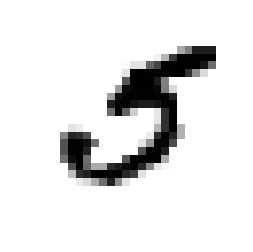

5

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image , cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()
y[36000] # looks like a five and that is also what is returned in the label

In [7]:
# creating a train and test set 

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Next step is to shuffle the data set guarantee that all cross-validation folds will be similar i.e. the cross-validations should contain representations of all digits. Moreover, some learning algorithms are sensitive to the order of the training intances, and they perform poorly if they get many similar instances in a row

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

Training a binary classifier, being able to identify the number 5. And training a classifier, starting with Stochastic Gradient Descent as it handles training instances independantly and hence is good for online learning. 

In [9]:
# picking out number five indicies - true when equal to five, false otherwise

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


In [10]:
# starting out with a SGD

from sklearn.linear_model import SGDClassifier 

# random state indicates how the data should be shuffled. 

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])
    

array([ True])

### Performance measures 

Evaluating a classifier is often significantly trickier than evaluating a regressor. This is due to many reasons. E.g. if the data set is skewed then a dummy-classifier could get almost the samy accuracy by just predicting not-class or is-class all the time e.g. if the data set contains only 10% 5-digits then guessing not five all the time would yield a accuracy of 90% which seems farily good. However, there are better methods to actually get a grasp over the model performance. 

In [11]:
# implementing cross-validation using StratifiedKFold 

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits = 3, random_state = 42) # returns stratified folds

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # new estimator with the same parameters 
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.9502
0.96565
0.96495


In [12]:
# implementing a dummy classifier 

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator): 
    def fit(self, X, y = None):
        pass
    def predict(self, X): 
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()

from sklearn.model_selection import cross_val_score
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

# getting almost the same accuracy when only predicting not five. 

array([0.909  , 0.90715, 0.9128 ])

### Confusion matrix

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. Non-five images represents negative class and true predictions in negative class are called true negatives and false predictions are called false negatives. Conversly for the positive class (five images) it is called true or false positives

In [13]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the predictions made on each fold instead of the evaluation scores
# as compared to cross_val_score function

# cross_val_predict performs K-fold cross-validation

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [14]:
# getting the confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# 53272 true negatives and 1307 false positives as row 1 represents the non-negative five class 
# and row 2 represents true five class. 

# 1077 were classified as false negatives and 4344 as true positives

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

### Precision and recall

Precision is the accuracy of the positive predictions: 

Precision = TP / (TP + FP) 

Recall is the ratio of positive instances that are correctly detected by the classifier 

Recall = TP / (TP + FN)

In [18]:
# computing the precision and recall scores 

from sklearn.metrics import precision_score, recall_score

prec = precision_score(y_train_5, y_train_pred) # accuracy of positive predictions TP/ (TP + FP)

rec = recall_score(y_train_5, y_train_pred) # ratio of postitive instances that are correctly predicted

print(' Precision: {}\n Recall: {}'.format(prec, rec))

 Precision: 0.7687135020350381
 Recall: 0.801328168234643


This output tells us that roughly 76% of the positive predictions were actually positive regarding precision. For recall it tells ut that it predicted 80% correct of the positive instances. So when it claims an image represents an 5 it is correct only 76% of the time and it only detects 80% of the 5s. 

Combining precision and recall into a single metric is often convenient. The F1-score is the harmonic mean of precision and recall. The F1-score favours classifiers that have similar precision and recall - this is not always what one wants. For example if one would train a classifier to detect videos suitable for kids one would prefer a classifier that rejects some allowable ones (low recall) but keeps only safe ones (high precision). 

Increasing precision reduces recall, and vice versa. The precision/recall trade off


In [19]:
# computing the F1-score

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7846820809248555

### Precision/recall trade off 

In [27]:
# SGDClassifier bases it precitions on comparing a score for each example to some treshhold 

treshhold = 200000
y_scores = sgd_clf.decision_function([some_digit])

y_some_digit_pred = (y_scores > treshhold)
y_some_digit_pred

# raising the treshhold decreases recall 



array([False])

In [28]:
# deciding on what treshhold to use, using cross_val_score to get all scores of all instances in 
# training set 

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')


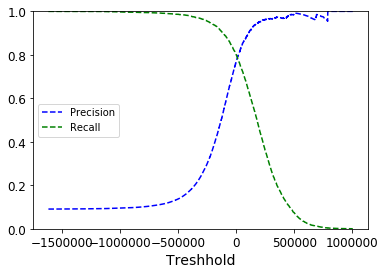

<Figure size 720x720 with 0 Axes>

In [34]:
# computing precision and recall for all possible treshholds using precision_recall_curve()

from sklearn.metrics import precision_recall_curve

precisions, recalls, treshholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_treshhold(precisions, recalls, treshholds): 
    plt.plot(treshholds, precisions[:-1], 'b--', label = 'Precision') 
    plt.plot(treshholds, recalls[:-1], 'g--', label = 'Recall')
    plt.xlabel('Treshhold')
    plt.legend(loc = 'center left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_treshhold(precisions, recalls, treshholds)
plt.show()

### ROC curve

the reciever operating characteristic (ROC) curve is another tool used with binary classifiers. it plots the true positive rate (recall) against the false positive rate where the FPR is the ratio of negative instances that are incorrectly classified as positive. I.e. 1 - true negative rate i.e. negative instances correctly classified as negative. TNR is called sensitivity. 

The ROC curve then plots recall vs 1 - sensitivity meaning the ratio of positive instances correctly classified versus false positive rate (1 - true negative ratio). 

The dotted line represents the ROC curve of a purely random classifier hence a good classifier stays as far away from that line as possible

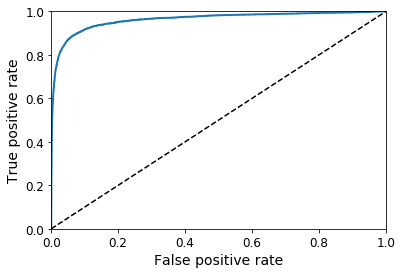

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None): 
    plt.plot(fpr, tpr, linewidth = 2, label = None)
    plt.plot([0, 1], [0, 1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [39]:
# compare classifiers via computing area under the curve (ROC AUC)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

### When to use which metric 

ROC-curve vs PR-curve. As a rule of thumb, one should prefer the PR curve whenever the positive class is rare or when you care more about false positives than false negatives, and the ROC curve otherwise. 

In [43]:
# comparing SGDClassifier() with RandomForestRegressor() and comparing ROC and ROC AUC metrics

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                   method = 'predict_proba')

y_probas_forest # returns probability that the instance belongs to one class or another (columns)

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

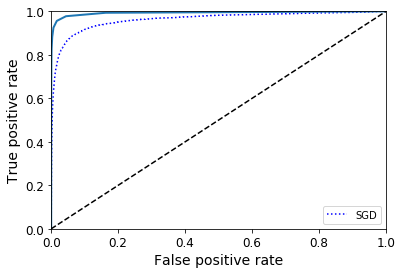

In [46]:
# converting probabilities to scores 

y_scores_forest = y_probas_forest[:, 1] # using the positives class probability as the score
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc =  'lower right')

# measuring the precision and recall 

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

### Multiclass Classification

Distinguishes between more than two classes. Random Forest and Naive Bayes classifiers are capable of handling multiple class directly. SVM and Linear Classifiers are strictly binary classifiers. However, there are various strategies that one can use to perform multiclass classification using multiple binary classifiers. 

In [50]:
# training SGD OvA classifier

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores
# for the image, and selected the class with the highest score 

array([5], dtype=int8)

In [52]:
# comparing decision scores

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

np.argmax(some_digit_scores)

5

In [53]:
# fitting a Random Forest Classifier 

# a random forest classifier can directly classify instances into multiple classes 

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [54]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [55]:
# evaluating the classifiers using cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

array([0.84063187, 0.84899245, 0.86652998])

In [58]:
# trying to improve the scoring by scaling the inputs

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.91011798, 0.90874544, 0.906636  ])

In [59]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
X_train_scaled_m = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled_m, y_train, cv = 3, scoring = 'accuracy')

array([0.88332334, 0.88259413, 0.88713307])

### Error analysis 



In [60]:
# analysing the error using a confusion matrix 

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [63]:
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

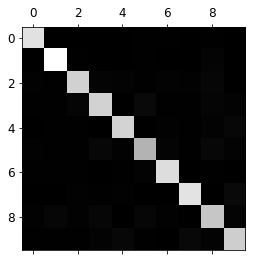

In [64]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

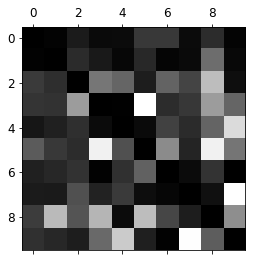

In [69]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

# rows represent actual classes while columns represent predicted classes 